# Assignment 3

## Part 1 - Improving the 5-point stencil in CUDA

### Used Packages for this assignment:

In [1]:
from numba import cuda
import numpy as np
import numba
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg
from matplotlib import pyplot as plt
import matplotlib.cm as cm

### Solution

Let us define the `discretise_poisson` from the Assignment 2 to create the comparison matrix using the CPU

In [2]:
def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

Now I define a new reduced system that only computes interior points with no boundary conditions, i.e. I can set the boundary values explicitly to zero. This new kernel also accepts an optional omega parameter so we can evaluate the modified Helmholtz problem later on. Different than the solution provided for Assignment 2 which only uses the global memory, this kernel will use the shared memory to perform the computation.

Let's consider N equals 100.

The idea is the following:
- The kernel will only act on the interior points, i.e. (100-2)² = 9604 values
- Each block will contain(32x32) threads, resulting in 1024 points per block
- Each local thread gets its respective value from the global memory
- We still need to handle the boundary values for that block since the 5 points-stencil depends on it
- So what we do is to load one extra line and one extra column into the shared-memory ((32 +1) x( 32 +1))
- The threads that are on the edge of their own block load the corresponding next, previous, above, and below points depending on where the thread is (the logic happens from lines 27 to 44).
- Once we have our local sub-grid we can just compute the values as we did for the second assignment


In [3]:
#shared_size = (32 + 2) ** 2 #if nblocks > 1 else (N) ** 2

@cuda.jit
def evaluate_discrete_laplace_with_shared_mem(vec_in, vec_out, N, omega):
    """Evaluate the discrete Laplace operator."""
    i, j = cuda.grid(2)

    if i >= N:
        return
    if j >= N:
        return
    
    nblocks = cuda.gridDim.x
    thread_count = cuda.blockDim.x
    
    local_points = cuda.shared.array(shape=(shared_size), dtype=numba.float32)

    ti = cuda.threadIdx.x
    tj = cuda.threadIdx.y
    
    if ti == 0 and tj == 0:
        for a in range(shared_size):
             local_points[a] = 0

    cuda.syncthreads()
    
    k = j * N + i
    block_size = thread_count+2 if nblocks > 1 else N+2
    local_i = ti + 1
    local_j = tj+1
    local_k = local_j * (block_size) + local_i
    local_points[local_k] = vec_in[k]
    if(ti == thread_count - 1 and cuda.blockIdx.x < (nblocks-1)):
        local_points[local_k + 1] = vec_in[k + 1]
    if(ti == 0 and i != 0):
        local_points[local_k - 1] = vec_in[k - 1]
    if(tj == thread_count - 1 and cuda.blockIdx.y < (nblocks-1)):
        k_below = (local_j + 1) * (block_size) + local_i
        local_points[k_below] = vec_in[(j+1) * N + i]
    if(tj == 0 and j != 0):
        k_above = (local_j + -1) * (block_size) + local_i
        local_points[k_above] = vec_in[(j-1) * N + i]

    cuda.syncthreads()

    local_r = local_k + 1
    local_l = (local_k - 1)
    local_u = (local_j + 1) * (block_size) + local_i
    local_d = (local_j - 1) * (block_size) + local_i

    left = local_points[local_l]
    up = local_points[local_u]
    down = local_points[local_d]
    right = local_points[local_r]
    center = local_points[local_k]

    delta_u = ((N+2) - 1)**2 * (numba.float32(4) *
                                center - up - down - left - right)
    vec_out[k] = delta_u + (omega**2)*center


def eval_gpu_shared_mem(x, N, omega=0):
    res = np.zeros((N-2) ** 2, dtype=np.float32)
    nblocks = (N-2 + (32-1)) // 32
    evaluate_discrete_laplace_with_shared_mem[(nblocks, nblocks),(32, 32)](x.astype('float32'), res, N-2, omega)
    return res.astype('float64')

In [4]:
rand = np.random.RandomState(0)

N = 500
#32x32 threads per block
shared_size = (32 + 2) ** 2

A, _ = discretise_poisson(N)

def remove_boundaries(A, N):
    return np.copy(A.reshape((N,N))[1:N-1,1:N-1]).reshape(((N-2) ** 2))

def set_zero_to_the_boundaries(x, N):
    x_m = np.copy(x.reshape((N,N)))
    x_m[0,:] = 0
    x_m[:, 0] = 0
    x_m[N-1,:] = 0
    x_m[:, N-1] = 0
    return x_m.reshape((N * N))

x = rand.randn(N * N)

x_zero_boundary = set_zero_to_the_boundaries(x, N)
x_tilde = remove_boundaries(x_zero_boundary, N)

A_tilde = eval_gpu_shared_mem(x_tilde, N)
y_cpu = remove_boundaries((A @ x_zero_boundary), N)

rel_error = np.linalg.norm(y_cpu - A_tilde, np.inf) / np.linalg.norm(y_cpu, np.inf)
print(f"Relative errorr: {rel_error}.")

Relative errorr: 1.1318467088783189e-07.


The difference between the implementations is the same as we had for assignment 2 when N is 500.

When we do the computation on the GPU, we change the precision to the order of 32 bits. We do that because GPUs are usually designed to better work with single precision digits.

### Benchmark

For benchmark comparison we first define the GPU code provided for the Assignment 2 that only uses the global memory for the computation

In [5]:
@cuda.jit
def evaluate_discrete_laplace(vec_in, vec_out, N):
    """Evaluate the discrete Laplace operator."""
    
    i, j = cuda.grid(2)
    
    if i >= N:
        return
    if j >= N:
        return
    
    # Compute the vector index
    k = j * N + i
    
    if i == 0 or i == N - 1 or j == 0 or j == N - 1:
        # We are at the boundary
        # Here, the matrix just acts like the identity
        vec_out[k] = vec_in[k]
        return
    
    # Now deal with the interior element
    
    up = vec_in[(j + 1) * N + i]
    down = vec_in[(j - 1) * N + i]
    left = vec_in[j * N + i - 1]
    right = vec_in[j * N + i + 1]
    center = vec_in[k]
    vec_out[k] = (N - 1)**2 * (numba.float32(4) * center - up - down - left - right)
    
def eval_gpu(x, N):
    """Evaluate the discrete Laplacian on the GPU."""
    
    res = np.zeros(N * N, dtype=np.float32)
    
    nblocks = (N + 31) // 32
    evaluate_discrete_laplace[(nblocks, nblocks), (32, 32)](x.astype('float32'), res, N)
    return res.astype('float64')

We will benchmark the values using the CPU, and GPU implementations. For the GPUs, we will compare the solution that only uses the global memory and also the new supposed optimised shared memory solution.

In [6]:
def benchmark(N):
    """Benchmark the CPU and GPUs implementations."""
    
    A, _ = discretise_poisson(N)
    x = rand.randn(N * N)
    
    x_zero_boundary = set_zero_to_the_boundaries(x, N)
    x_tilde = remove_boundaries(x_zero_boundary, N)
    
    print("CPU Benchmark")
    %timeit y_cpu = A @ x_zero_boundary
    
    print("GPU Benchmark Global Memory only")
    %timeit eval_gpu(x_zero_boundary, N)
    
    print("GPU Benchmark Shared Memory")
    %timeit eval_gpu_shared_mem(x_tilde, N)
    

print("Small size benchmark (n=100)")
print("----------------------------")
benchmark(100)
print("Large size benchmark (n=3000)")
print("-------------------------------")
benchmark(3000)

Small size benchmark (n=100)
----------------------------
CPU Benchmark
54.8 µs ± 7.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
GPU Benchmark Global Memory only
934 µs ± 59.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
GPU Benchmark Shared Memory
947 µs ± 20.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Large size benchmark (n=3000)
-------------------------------
CPU Benchmark
99.4 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
GPU Benchmark Global Memory only
65.3 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
GPU Benchmark Shared Memory
104 ms ± 819 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The processor used for this benchmark is an i7-7700HQ and the GPU used was a GeForce GTX 1050

The benchmark results show that the CPU is faster for small sizes of N since it does not have the bottleneck of transferring data to the GPU and back to the CPU.

For large sizes of N, we can note that the GPU performance overcomes the CPU. Our new solution, using the shared memory has shown to be a couple of milliseconds faster compared to the previous solution which only uses global memory access. I could also notice that the larger your grid is (N), the greater will be the performance difference between the two GPUs. Therefore, we can say this new solution is better for large and very large grids compared to the previous GPU solution

## Part 2  - Solving modifed Helmholtz problems with CG on the GPU

### Plots of the convergence curves for different values of ω

let's use the `scipy.sparse.linalg.LinearOperator` to wrap our solution from part 1
For this example, we will use the `omega` parameter with different values and see what the convergence curve is like when solving the linear system of equations with `scipy.sparse.linalg.cg`.

Since we only have interior ponts, `f` is just a function with all ones.

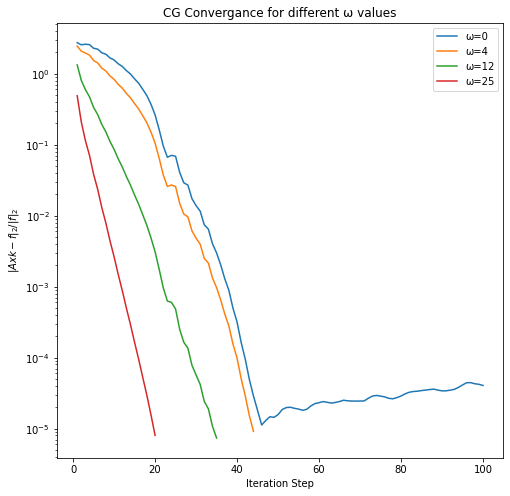

In [7]:
%matplotlib inline

N = 34

def get_linearOperator(N, omega):
    return LinearOperator(((N-2) ** 2, (N-2) ** 2),
                          matvec=lambda vector: eval_gpu_shared_mem(vector, N, omega))


def callback(x, matrix, residuals): return residuals.append(
    np.linalg.norm(f - matrix @ x) / np.linalg.norm(f))

A = get_linearOperator(N, 0)

A2 = get_linearOperator(N, 4)

A3 = get_linearOperator(N, 12)

A4 = get_linearOperator(N, 25)

f = np.ones((N-2) ** 2)

residuals = []
residuals2 = []
residuals3 = []
residuals4 = []

sol, _ = cg(A, f,  callback=lambda x: callback(x, A, residuals), maxiter=100)
sol, _ = cg(A2, f,  callback=lambda x: callback(x, A2, residuals2), maxiter=100)
sol, _ = cg(A3, f,  callback=lambda x: callback(x, A3, residuals3), maxiter=100)
sol, _ = cg(A4, f,  callback=lambda x: callback(x, A4, residuals4), maxiter=100)

plt.figure(figsize=(8,8))
plt.semilogy(1 + np.arange(len(residuals)), residuals, label = "ω=0")
plt.semilogy(1 + np.arange(len(residuals2)), residuals2, label = "ω=4")
plt.semilogy(1 + np.arange(len(residuals3)), residuals3, label = "ω=12")
plt.semilogy(1 + np.arange(len(residuals4)), residuals4, label = "ω=25")

plt.xlabel('Iteration Step')
plt.ylabel('$\|Axk-f\|_2 / \|f\|_2$')
plt.title('CG Convergance for different ω values')
plt.legend()
plt.show()

We can see here that the greater the omega is, the quicker the solution converges. CG converges quicker when eigenvalues are clustered together than if they were irregularly distributed between lambda_min and lambda_max. The further we shift the cluster of eigenvalues from the origin, the quicker the convergence. 

Also, the convergence of CG can be improved depending on how close the minimizing error polynomial can be to zero on each eigenvalue

### Solution Visualisation

Let's visualise our PDE solution for ω=1

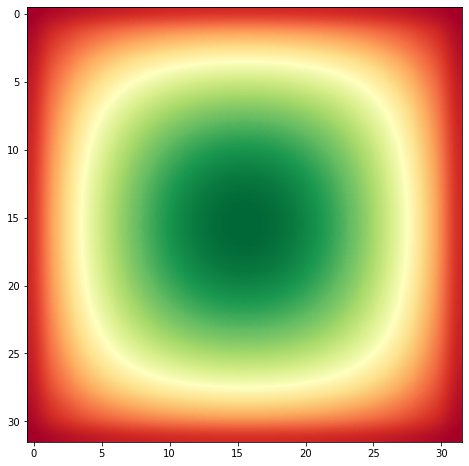

In [8]:
A = get_linearOperator(N, 1)
sol, _ = cg(A, f, maxiter=100)
U = sol.reshape((N-2, N-2))
_, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(U, interpolation='lanczos', cmap=cm.RdYlGn)
plt.show()